# Auditing Allocative Bias

### Introduction  

In this blog post, I will create a machine learning model that predicts employment status based on census data. The goal of this project is to analyze bias with respect to race within the data. To reach this conclusion, I will perform a series of steps. First, I will load my dataset and select a certain US state to analyze. Next, I will wrangle my data and perform pre-processing steps. Then, I will fit a classification model and obtain prediction values. Finally, I will implement a fairness audit to assess the bias (or lack thereof) within my model.

### Step 1: Get data

The first step is to import my data. For this project, we will be using data from the American Community Survey’s Public Use Microdata Sample. I have chosen to focus on Massachusetts, as this is my home state.

In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000024,1,1,3301,1,25,1013097,47,77,...,47,46,4,92,46,50,49,4,89,4
1,P,2018GQ0000063,1,1,1600,1,25,1013097,16,18,...,33,30,16,16,18,2,18,31,16,15
2,P,2018GQ0000075,1,1,703,1,25,1013097,60,28,...,110,116,57,8,60,107,60,62,109,110
3,P,2018GQ0000088,1,1,3301,1,25,1013097,72,22,...,71,74,10,10,129,128,10,73,128,70
4,P,2018GQ0000098,1,1,701,1,25,1013097,21,50,...,37,18,24,0,39,19,20,39,19,36


As you can see from the data, there are an abundance of features to work with. As we know, machine learning models can be prone to overfitting when given too many feature variables. As a result, let's focus on a subset of variables:

### Step 2: Subset the features

In [2]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,77,19.0,3,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,1,6.0
1,18,18.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,9,1.0
2,28,21.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,1.0
3,22,19.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
4,50,1.0,5,17,1,NaN,1,1.0,4.0,1,1,2,1,1.0,2,1,6.0


For the sake of this project, we will only be focusing on Caucasian vs African American citizens. Therefore, we can filter our dataset for just these groups (1 corresponds to white, 2 corresponds to black).

In [3]:

df = acs_data
df = df[df['RAC1P'].isin([1, 2])]

To make our feature matrix, we want to include all the possible features except for two:  

    ESR: Our target variable, employment status  
    RAC1P: Race of citizen  

In [4]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]


### Step 3: Construct employment problem

Now we can construct a BasicProblem that expresses our wish to use these features to predict employment status ESR, using the race RAC1P as the group label. Our implementation will return the following:  

    features: Our feature matrix  
    label: our y (target vector)  
    group: a 1d array with the race of each row  

In [5]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(df)

### Step 4: Train / Test split

As with any good machine learning model, creating a train/test split for our data will be important for testing our algorithm and to prevent overfitting. The split will return the following data:   

    X_train: our training subset of the feature matrix  
    X_test: our testing subset of the feature matrix  
    y_train: our training subset of the target vector  
    y_test: our testing subset of the target vector  
    group_train: our training subset of the group vector  
    group_test: our testing subset of the group vector  

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

### Step 4: Exploratory data analysis

To perform EDA, it will be helpful to revert our dataset back to a pandas dataframe.  
  
Let's also add our target vector and group vector back.

In [7]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,51.0,16.0,3.0,13.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
1,34.0,16.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
2,52.0,20.0,2.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,False
3,75.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1,False
4,11.0,9.0,5.0,7.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48914,6.0,2.0,5.0,7.0,2.0,7.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,2.0,1.0,1,False
48915,49.0,21.0,3.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,2.0,1,False
48916,13.0,10.0,5.0,2.0,2.0,7.0,1.0,3.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
48917,56.0,19.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,True


Using this data frame, let's analyze some common questions:  

##### 1. How many individuals are in the data?

In [8]:
num_citizens = len(df)
print(f"There are {num_citizens} citizens in the dataset")

There are 48919 citizens in the dataset


##### 2. Of these individuals, what proportion have target label equal to 1? 

In [9]:
percent = round((df['label'] == True).mean(), 2) * 100
print(f"Percentage of employed individuals: {percent}%")

Percentage of employed individuals: 51.0%


##### 3. Of these individuals, how many are in each of the groups?

##### Let's separate by group

In [10]:
white = df[df['group'] == 1]
black = df[df['group'] == 2]

white_count = len(white)
black_count = len(black)

print(f"Number of white: {white_count}\nNumber of black: {black_count}")


Number of white: 45557
Number of black: 3362


It is important to note that there are significantly more white entries than black!

##### 4. In each group, what proportion of individuals have target label equal to 1?

In [11]:
white_percent = round((white['label'] == True).mean(), 2)
black_percent = round((black['label'] == True).mean(), 2)

print(f"Percentage of white: {white_percent}\nPercentage of black: {black_percent}")

Percentage of white: 0.51
Percentage of black: 0.46


From this experiment, we can see that 51% of white citizens are employed compared to 46% of black citzens

##### 5. Intersectional trends

In [12]:
new_df = df.copy()
new_df['SEX'] = new_df['SEX'].replace({1: 'M', 2: 'F'})
new_df['group'] = new_df['group'].replace({1: 'White', 2: 'Black'})

intersection = new_df.groupby(['group', 'SEX'])['label'].mean().reset_index(name = "Mean")
intersection


,group,SEX,Mean
0,Black,F,0.497336
1,Black,M,0.430365
2,White,F,0.491007
3,White,M,0.537750


Let's visualize this!

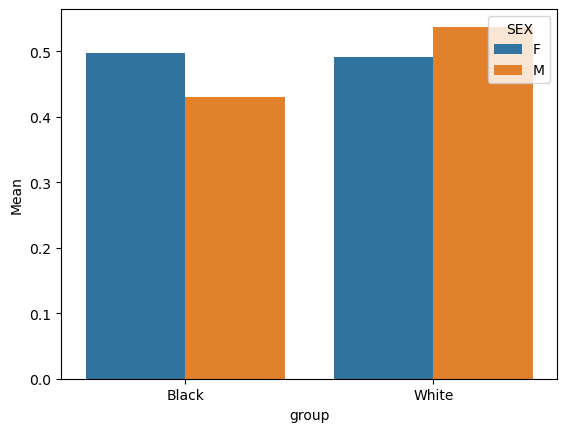

In [13]:
import seaborn as sns
ax = sns.barplot(data=intersection, x= 'group', y='Mean', hue = 'SEX')

As we can see, for black citizens, females have a higher employment percentage (+5%)
  
However, for white citizens, males have a higher employment percentage (+4%)

### Step 5: Create model

Now, we will train a model in order to attempt classifying citizen employment. For this problem, we will use a decision tree. We could have used almost any classification model (SVM, Random forest, Logistic regression, etc.), but because we have a very large dataset, utilizing the decision tree efficiency makes sense.  

First, let's import the class from sklearn

In [14]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

In the following code block, we perform the following operations:  

1. Loop through options for the depth hyperparameter. In each iteration, we will....  
    1. Create a tree with the respective max_depth  
    2. Perform cross validation with 5 folds on our training data  
    3. Take the average of the scores and append to the tree_cv  
2. After the loop, we will choose the optimal depth from our array using the argmax method  
3. Fit a new tree with our optimal depth  
4. Get the accuracy after testing on our training data  

In [15]:
tree_cv = []

for depth in range(1, 10):

    t = tree.DecisionTreeClassifier(max_depth=depth)
    cv_scores_tree = cross_val_score(t, X_train, y_train, cv=5)
    tree_cv.append(np.mean(cv_scores_tree))

# Get top depth and fit on entire training
optimal_depth = np.argmax(tree_cv) + 1
print("Optimal depth: " + str(optimal_depth))
t = tree.DecisionTreeClassifier(max_depth=optimal_depth)
t.fit(X_train, y_train)
tree_score = t.score(X_train, y_train)

print("Accuracy: " + str(tree_score))



Optimal depth: 9
Accuracy: 0.8354831456080459


### Step 6: Audit & Metrics

Now, we will perform an audit to assess bias / fairness. We will start with overall metrics, and then we will split our data up by group and perform by-group assessment.

First, let's use our test data to make predictions.

In [16]:
y_hat = t.predict(X_test)

#### Overall Metrics

##### Accuracy

In [17]:
(y_hat == y_test).mean()

0.8291087489779232

##### Positive Prediction Value (PPV)  

The PPV is a performance metric that measures the proportion of positive predictions that are actually true positive cases. It is also known as the precision. It is particularly useful in situations where the cost of a false positive is high. In our project, it will not be as important as other metrics, but it is still useful to analyze.

    PPV = TP/(TP + FP)

In [18]:
from sklearn.metrics import precision_score
ppv = precision_score(y_test, y_hat)
ppv 

0.8070382966139288

##### Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
cm = confusion_matrix(y_test, y_hat, normalize='true')
cm

array([[0.78202773, 0.21797227],
       [0.12574083, 0.87425917]])

##### False Negative Rate (FNR) and False Positive Rate (FPR)  

    FNR = FN/(FN + TP)  
    FPR = FP/(FP + TN)

In other words, the false negative rate is the proportion of actual positive cases that are incorrectly classified as negative, while the false positive rate is the proportion of actual negative cases that are incorrectly classified as positive by our model.  

An imbalance in these metrics among groups could be representative of bias within the model. Before breaking up our data into sections, let's analyze the whole group metrics.

In [21]:
# False negative rate

FN = cm[1, 0]
TP = cm[1, 1]
FNR = round(FN/(FN + TP), 2) * 100


# False positive rate

FP = cm[0, 1]
TN = cm[0, 0]
FPR = round(FP/(FP + TN), 2) * 100

print(f"False Negative rate: {FNR}%\nFalse Positive Rate: {FPR}%")

False Negative rate: 13.0%
False Positive Rate: 22.0%


From these calculations, we see that our model has a higher FPR than FNR. This implies that our model over-predicts the number of employed citizens. Now, let's split our data into groups:

#### By-Group Measures

##### Split into subsets by race

In [22]:
is_white = group_test == 1
is_black = group_test == 2

y_hat_black = y_hat[is_black]
y_hat_white = y_hat[is_white]

y_test_black = y_test[is_black]
y_test_white = y_test[is_white]


First, let's analyze the accuracy for both races.

##### White Accuracy

In [23]:
round((y_hat_white == y_test_white).mean(), 3)

0.829

##### Black Accuracy

In [24]:
round((y_hat_black == y_test_black).mean(), 3)

0.831

The accuracy for the two groups are just about equal. How about the PPV?

##### White PPV

In [25]:
ppv_white = precision_score(y_test_white, y_hat_white)
round(ppv_white, 3)

0.808

##### Black PPV

In [26]:
ppv_black = precision_score(y_test_black, y_hat_black)
round(ppv_black, 3)

0.785

Now, let's output the confusion matrices for both groups.

##### White Confusion matrix:

In [27]:
white_confusion = confusion_matrix(y_test_white, y_hat_white, normalize='true')

In [28]:
white_confusion

array([[0.78064633, 0.21935367],
       [0.12534106, 0.87465894]])

##### Black Confusion Matrix

In [29]:
black_confusion = confusion_matrix(y_test_black, y_hat_black, normalize='true')

In [30]:
black_confusion

array([[0.79910714, 0.20089286],
       [0.13192612, 0.86807388]])

From a first glance, these confusion matrices seem pretty equal. the model is very accurate in predicting true negatives, and a little less accurate in predicting true positives. When the model misses for both groups, it is usually towards a false negative. Now, we will analyze the FNR and FPR for both groups.

##### FNR and FPR

In [31]:
# White metrics

# False negative rate

FN_W = white_confusion[1, 0]
TP_W = white_confusion[1, 1]
FNR_W = round(FN_W/(FN_W + TP_W), 2) * 100


# False positive rate

FP_W = white_confusion[0, 1]
TN_W = white_confusion[0, 0]
FPR_W = round(FP_W/(FP_W + TN_W), 2) * 100

print(f"False Negative rate (White): {FNR_W}%\nFalse Positive Rate (White): {FPR_W}%")

# Black metrics

# False negative rate

FN_B = black_confusion[1, 0]
TP_B = black_confusion[1, 1]
FNR_B = round(FN_B/(FN_B + TP_B), 2) * 100


# False positive rate

FP_B = black_confusion[0, 1]
TN_B = black_confusion[0, 0]
FPR_B = round(FP_B/(FP_B + TN_B), 2) * 100

print(f"False Negative rate (Black): {FNR_B}%\nFalse Positive Rate (Black): {FPR_B}%")

False Negative rate (White): 13.0%
False Positive Rate (White): 22.0%
False Negative rate (Black): 13.0%
False Positive Rate (Black): 20.0%


Here, we see a slight difference in the FPR for white and black individuals. This disparity represents slight predictive inequality. Although only 2%, in a massive dataset (like censuses), this can affect hundreds of citizens and is a true example of predictive bias.

#### Bias measures

##### Calibration

<Axes: xlabel='y_pred', ylabel='y'>

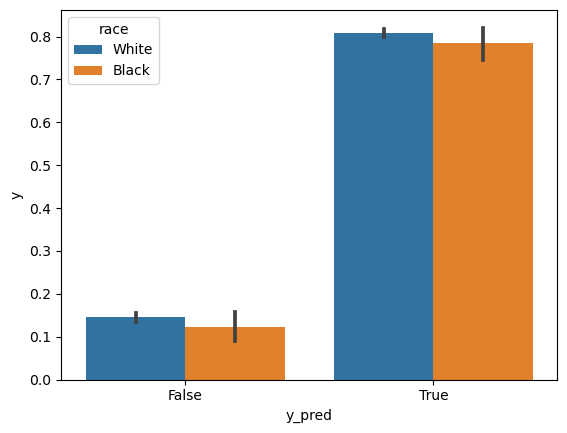

In [32]:
calibration = pd.DataFrame(X_test, columns = features_to_use)
calibration['y_pred'] = y_hat
calibration['y'] = y_test
calibration['race'] = group_test
calibration['race'] = calibration['race'].replace({1: 'White', 2: 'Black'})

means = calibration.groupby(["race", "y_pred"])["y"].mean().reset_index(name = "mean")
sns.barplot(data = calibration, x = "y_pred", y = "y", hue = "race")

In our calibration plot, we see that slightly more white than black defendants are actually employed compared to the predictions. This plot is otherwise very balanced and I would argue our model is calibrated.

##### Error rate balance

In [33]:
ERB = 100 * (FP - (FNR/100)) / ( (FPR/100) + (FNR/100) )
ERB

25.13493521677922

We have a fairly positive ERB, which implies that our false positive rate is higher than our false negative rate. In other words, our model predicts that unemployed individuals are employed more frequently than it predicts employed individuals are unemployed.

In [34]:
PPR_white = (TP_W + FP_W) / (TP_W + FP_W + TN_W + FN_W)
PPR_black = (TP_B + FP_B) / (TP_B + FP_B + TN_B + FN_B)

ratio = PPR_black/PPR_white
round(ratio, 2)

0.98

There is a slight disparity favoring white individuals, which suggests these individuals receive slightly more positive predictions from the model. Once again, although this difference is very small, in a massive dataset, there could be a noticeable impact, so it is worth mentioning.

### Conclusion

In conclusion, our model is slightly biased towards white people. We see this disparity when calculating the PPV, FPR and error rate balance. Let's go into a little more detail about potential stakeholders in the context of the employment problems.   

1. <b>Who could benefit?</b> 

    <u>Hiring agencies</u>: For companies that make money off of recruitment / hiring, this algorithm could be utilized to narrow down just those who are unemployed. This could save the company time and money.  

    <u>Job search agencies</u>: Think about Indeed, Handshake, etc. If they can predict who is unemployed, they can improve recommendations and success rates.  

    <u>Economists</u>: This algorithm could be used to analyze macro-trends in our society and therefore implement regulations into our society to shift employment rates.

2. <b>Who could be the impact?</b>

    In general, any discrimination will lead to bias being leaked into our society. This bias could affect hiring decisions, bank loans, policy implementation, and general sentiment. Even though the discrepancy in the model is small, positive feedback loops of bias could create long term problems.

3. <b>Problematic bias?</b>  

    It is hard to tell how problematic this bias could be. As I mentioned, there is a disparity in the FPR and the error rate balance. Even though these biases are small, it is difficult to imagine the effect they could have at the scale of a country like the USA.

4. <b>Other problems?</b>

    As with any model that uses big data (especially census data), the issue of privacy is present. This is real data, taken from real surveys, and therefore any model predicting behaviors of citizens is going to be contentious.

    

### Hope you enjoyed this blog!